We have picked Boeing because earlier in our analysis as a node it has shown more edges than other companies. It is strongly connected to other airlies and energy companies.
Twitter data regarding Boeing was accessed through Twitter API.

Importing necessary libraries for the analysis


In [53]:
import tweepy
from textblob import TextBlob
from wordcloud import wordcloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from scipy import stats as stat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import json
import yfinance as yf
import sys
import jsonpickle
import os
import re
from afinn import Afinn
from datetime import datetime
from datetime import timezone  


Importing Twitter Api credential. Credentials such as consumer key, consumer secret was added through a CSV file for security reason.

In [8]:
log1 = pd.read_csv('login.csv')

In [9]:
ckey=log1['Key'][0]
cs=log1['Key'][1]
at = log1['Key'][2]
ats = log1['Key'][3]

In [10]:
#create the twitter authentication
aunthenticate = tweepy.OAuthHandler(ckey,cs)
aunthenticate.set_access_token(at,ats)
api = tweepy.API(aunthenticate,wait_on_rate_limit=True)

In [14]:
## Around 3238 tweets regarding Boeing is extracted.

searchQuery = 'Boeing' #'#someHashtag'  # this is what we're searching for
maxTweets = 10000# Some arbitrary large number
tweetsPerQry = 100 # this is the max the API permits
fNameb = 'tweetsb.txt' # We'll store the tweets in a text file..

Extracting tweets regarding boeing from Twitter:Search Query was implemented regarding Boeing.Boeng Twitter account was utilized to get the tweets.

In [15]:
# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id=-1
tweetCount = 0
#print("Downloading max {0} tweets".format(maxTweets))
with open(fNameb, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False,
                                count=tweetsPerQry)
                else:
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False,
                                count=tweetsPerQry,
                                max_id=str(max_id - 1),
                                since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False, 
                                count=tweetsPerQry,
                                max_id=str(max_id - 1))
                else:
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False, count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                #print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            #print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

The data was stored as a json object.

In [16]:
tweets_data_path = 'tweetsb.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

In [54]:
print(len(tweets_data))

3238


Incorporating tweets in a dataframe.

In [17]:
tweets = pd.DataFrame() #create pandas dataframe
tweets['TimeStamp'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
tweets['Name'] = list(map(lambda tweet: tweet["user"]["screen_name"], tweets_data))
tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets_data))
tweets['Favorites'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))
tweets['Retweet'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
tweets['in_reply_to_status_id_str'] = list(map(lambda tweet: tweet['in_reply_to_status_id_str'], tweets_data))
tweets['in_reply_to_screen_name'] = list(map(lambda tweet: tweet['in_reply_to_screen_name'], tweets_data))

In [18]:
tweets.head()

,TimeStamp,Name,text,lang,tweet_id,Favorites,Retweet,in_reply_to_status_id_str,in_reply_to_screen_name
0,Tue Jul 20 14:00:10 +0000 2021,Boeing,"Moscow International Air Show is back, and we’...",en,1417484479871004691,257,33,None,None
1,Mon Jul 19 23:21:31 +0000 2021,Boeing,The Orbital Flight Test-2 #Starliner rolled ou...,en,1417263361516048384,444,101,None,None
2,Wed Jul 14 12:26:47 +0000 2021,Boeing,"Sustainable aviation fuels, or SAF, offer the ...",en,1415286651425677314,92,20,None,None
3,Tue Jul 13 18:30:05 +0000 2021,Boeing,Ready to take your career to the next level? H...,en,1415015692521418762,44,8,None,None
4,Sun Jul 04 12:00:15 +0000 2021,Boeing,We're grateful for the unwavering spirit that ...,en,1411656096301948939,178,25,None,None


Cleaning tweets to have better understanding: To clean the data we extracted the user name, removed URL and RT,punctations and double space.

In [20]:
%%time

pd.options.mode.chained_assignment = None

#extract the username through the tweets (preceded by @ or by RT @)
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(' ')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('@')[i]  == False:
        tweets['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweets['text'])):
    tweets['text'][i] = " ".join([word for word in tweets['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])

Wall time: 50.9 s


In [21]:
#delete certains punctuations, put the text in lower case and delete the double space with the function apply
import re
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweets['text'] = tweets['text'].apply(lambda x: re.sub('  ', ' ', x))
tweets['text'][0]

'moscow international air show is back and we’ll be there in person on july 20-25 discussing our passenger and frei…'

Cleaning date column: Timestamp was formatted to datetime format to make it uniform to the Yahoo Finance dataset regarding Boeng.

In [23]:
tweets['TimeStamp'] = pd.to_datetime(tweets['TimeStamp'])
print (tweets)

                     TimeStamp    Name  \
0    2021-07-20 14:00:10+00:00  Boeing   
1    2021-07-19 23:21:31+00:00  Boeing   
2    2021-07-14 12:26:47+00:00  Boeing   
3    2021-07-13 18:30:05+00:00  Boeing   
4    2021-07-04 12:00:15+00:00  Boeing   
...                        ...     ...   
3233 2012-04-20 12:44:58+00:00  Boeing   
3234 2012-04-19 16:57:37+00:00  Boeing   
3235 2012-04-19 14:09:28+00:00  Boeing   
3236 2012-04-18 19:37:07+00:00  Boeing   
3237 2012-04-18 19:24:53+00:00  Boeing   

                                                   text lang  \
0     moscow international air show is back and we’l...   en   
1     the orbital flight test-2 starliner rolled out...   en   
2     sustainable aviation fuels or saf offer the gr...   en   
3     ready to take your career to the next level he...   en   
4     we're grateful for the unwavering spirit that ...   en   
...                                                 ...  ...   
3233  rt boeing sign agreement on mission suppo

In [25]:
tweets['TimeStamp'] = pd.to_datetime(tweets['TimeStamp'], unit='s')

In [26]:
tweets['date'] = pd.to_datetime(tweets['TimeStamp'].apply(lambda date: date.date()))

In [27]:
tweets['date'].head()

0   2021-07-20
1   2021-07-19
2   2021-07-14
3   2021-07-13
4   2021-07-04
Name: date, dtype: datetime64[ns]

Ticker symbol for Boeing from Yahoo Finance is identified. 

In [29]:
ba = tweets[tweets['Name'] == 'Boeing']

In [30]:
ba_stock = yf.Ticker('BA')

In [31]:
start = min(ba['date'])
end = max(ba['date'])

ba_stock= ba_stock.history(start=start.date(), end=end.date())

In [32]:
ba_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-04-18,60.561753,61.104979,60.471215,60.668751,2248900,0.0,0
2012-04-19,60.685220,60.874523,59.804531,60.166679,3729300,0.0,0
2012-04-20,60.306617,60.932155,60.166696,60.537083,4302100,0.0,0
2012-04-23,59.829226,60.191374,59.401224,59.969147,5022100,0.0,0
2012-04-24,60.257225,60.693453,59.895071,60.257225,3664500,0.0,0
...,...,...,...,...,...,...,...
2021-07-13,232.270004,234.490005,228.160004,228.199997,21029500,0.0,0
2021-07-14,229.020004,230.520004,224.300003,224.449997,12137000,0.0,0
2021-07-15,222.880005,226.669998,220.800003,222.759995,12228600,0.0,0


Firstly, we would like to find out if the amount of tweets affects the volume traded of the particular company. To do that,we made us of panda shift operator to shift the entire timeseries back by 1 period. By doing so, we will be able to compare the effects of the volume of tweets the day before on the particular company share price the following day. We have also decided to plot the volume traded and the volume of tweets in the same graph to visualise the data for a overview of the relationship between these 2 variables. To get a clearer picture of how these two variables correlates, we had to use the rolling operator to get the average of 30 days window to have a clearer senses of the overall trend.



In [34]:
ba_stock = yf.Ticker("BA").history(start=min(ba['date']).date(),end=max(ba['date']).date())

In [35]:
def tweet_vol_affect(tweets,stocks,title):
    tweet_shift1 = tweets.groupby('date').size().shift(-1).dropna() 
    stock_data = stocks['Volume'].dropna()
    corr, pval = stat.spearmanr(tweet_shift1.reindex(stock_data.index), stock_data,nan_policy='omit')
    tweets_vol = tweets.groupby('date').size().rolling(30).mean().dropna()
    stocks_data = stocks['Volume'].rolling(30).mean().dropna()
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot()
    ax2 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(tweets_vol.index,tweets_vol,label='Tweet Volume')
    ax2.plot(stocks_data.index,stocks_data,color='orange',label='Trade Volume')
    ax2.set_title(title+" \n Spearman correlation: corr={0:.5f} pval={1:.5f}".format(corr,pval))
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()

C:\Users\malia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


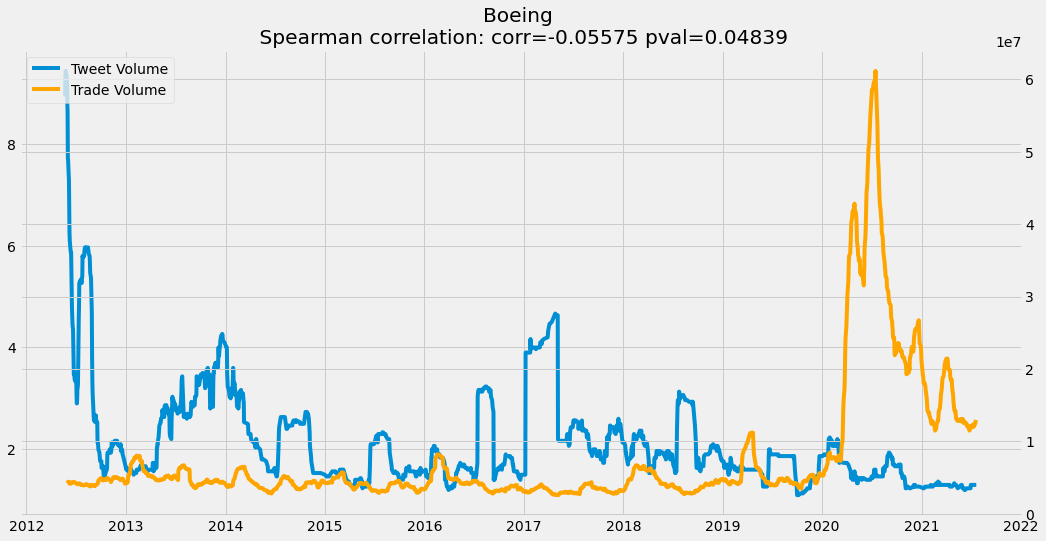

In [37]:
tweet_vol_affect(ba,ba_stock,"Boeing")   

The correlation between the tweets and trading is negatively correlated. Untill 2018 when tweet was high the trading volume was low. However,around 2020 the tweeting about Boeing went down and the trading volume went up.COVID 19 might have an affect regarding lower buzz in the Twitter.

Visualizing positive and negative tweets for boeing

### Sentiment Analysis
In order to identify the sentiment of the tweets, we will be using the Afinn library.In general, the afinn library will be able to provide a score where 0 is neutral, negative value would mean that the tweet is negative while postive would be otherwise.

In [40]:

afinn = Afinn()

In [41]:
ba['score'] =  ba['text'].apply(lambda tweet: afinn.score(tweet))

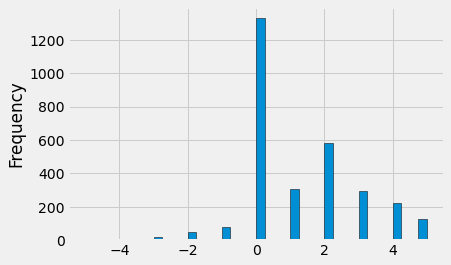

In [42]:
ba.score.plot(kind='hist',range=(-5,5),bins=40,edgecolor='black');

The tweet regarding the Boeing is mostly neutral.As the Tweet was scraped from Boeing timeline.

In [43]:
def sentiment_overtime(tweets,stock,title):
    visual= tweets.groupby('date')['score'].mean().shift(-1).rolling(30).mean().dropna()
    corr_test = tweets.groupby('date')['score'].mean().shift(-1).dropna()
    corr, pval = stat.spearmanr(corr_test.reindex(stock.index), stock['Open'],nan_policy='omit')

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot()
    ax2 = fig.add_subplot()
    ax2 = ax1.twinx()
    
    ax1.plot(visual.index,visual,label='Tweets Sentiment')
    ax2.plot(stock.index,stock['Close'],color='orange',label='share price')
    ax2.set_title("Effects of "+title+" tweets to shareprice" +"\n Spearman correlation: corr={0:.5f} pval={1:.5f}".format(corr,pval))
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()

C:\Users\malia\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


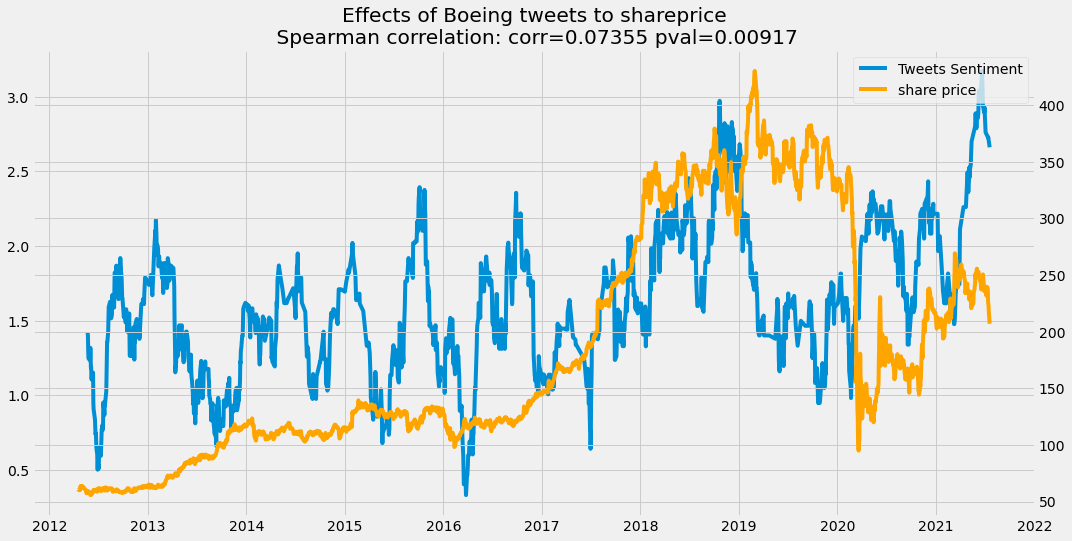

In [44]:
sentiment_overtime(ba,ba_stock,"Boeing");

The correlation between the twitter sentiment of Boeing Twitter page and the stock price was not strong until 2018. However around 2018 the positive sentiment in Boeing Twitter has shown some positive relationship with the share price

However The tweets were extracted from Boeing Twitter webpage. We can observe that around 2016 the stock price went down, even though the Twitter accound was refecting positive sentiment. In 2016, Emirates Flight 521 was a scheduled international passenger flight from Thiruvananthapuram, India, to Dubai, United Arab Emirates, operated by Emirates using a Boeing 777-300.  unfortunately, the aircraft carrying 282 passengers and 18 crew crashed while landing at Dubai International Airport.This shows the positive sentiment Boeing reflected on its' Twitter account has not improved the Stock price.

After the analysis it can be concluded Twitter account of Boeing has a negative correlation with the stock volume. And also somewhat opposite relationship with positive sentiment in their own twitter page and stock price.